In [115]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

# NLTK/NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk import FreqDist, word_tokenize
import string, re
import urllib
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.collocations import *
import gensim
from gensim.models import KeyedVectors

# Classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifierX

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import scikitplot as skplt

#Sampling
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# miscellaneous
from sklearn.utils import resample
import sklearn.decomposition as decomposition

import warnings 
warnings.filterwarnings("ignore")

import csv
import pickle

%run my_functions.ipynb

In [3]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [4]:
df.head()

,id,label,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,29727,0,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre engrus ...,"[sad, to, see, the, scenes, of, hooligans, pre...","[sad, to, see, the, scene, of, hooligan, pre, ...","[sad, to, see, the, scene, of, hooligan, pre, ...",sad to see the scenes of hooligans pre engrus ...,sad to see the scenes of hooligans pre engrus ...
1,14466,0,#gooddyeyoung #yoyoyo !! super happy to be ap...,#gooddyeyoung #yoyoyo super happy to be apa of...,gooddyeyoung yoyoyo super happy to be apa of t...,"[gooddyeyoung, yoyoyo, super, happy, to, be, a...","[gooddyeyoung, yoyoyo, super, happi, to, be, a...","[gooddyeyoung, yoyoyo, super, happy, to, be, a...",gooddyeyoung yoyoyo super happy to be apa of t...,gooddyeyoung yoyoyo super happy to be apa of t...
2,18194,0,queen evil's bihdayð#lnic #lnicjustanevilbd...,queen evil s bihday #lnic #lnicjustanevilbday ...,queen evil s bihday lnic lnicjustanevilbday bi...,"[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...",queen evil s bihday lnic lnicjustanevilbday bi...,queen evil s bihday lnic lnicjustanevilbday bi...
3,18283,1,@user you might be a libtard if... #libtard #...,you might be a libtard if #libtard #sjw #liber...,you might be a libtard if libtard sjw liberal ...,"[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...",you might be a libtard if libtard sjw liberal ...,you might be a libtard if libtard sjw liberal ...
4,25845,0,what are your goals? find out here... #smile...,what are your goals find out here #smile,what are your goals find out here smile,"[what, are, your, goals, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]",what are your goals find out here smile,what are your goals find out here smil


## Train / Val / Test Split

In [5]:
X = df.drop(['label'], axis = 1)

In [6]:
y = df['label']

In [7]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [8]:
#splitting "model" into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify = y_model, test_size=0.20, random_state=123)

## Comparing Vectorization and Method Performance

In [107]:
#initializing vectors and creating list for wrapper comparison function

count_vect = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(min_df=.001)
tfidf_ngram = TfidfVectorizer(ngram_range=(1,2), min_df=.001)
tfidf_ngram2 = TfidfVectorizer(ngram_range=(2,3),min_df=.001)

vectorization_list = [('COUNT_VECTORIZER', count_vect),
                      ('TFIDF_VECTORIZER', tfidf_vectorizer),
                      ('TFIDF_NGRAM_1_2', tfidf_ngram),
                      ('TFIDF_NGRAM_2_3', tfidf_ngram2)]



# Multinomial Naive Bayes (MNB)

#### Initial Comparision: Multiple Vectorizer and Class Balance Corrections

In [ ]:
np.random.seed(0)

In [36]:
#MNB with no class balance corrections
nb_results1 = compare_vectorization_model(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), vectorization_list)

nb_results1

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.97,0.94,0.94,0.93
Train F1,0.74,0.36,0.37,0.14
Train Precision,0.83,0.90,0.91,0.89
Train Recall,0.66,0.23,0.23,0.08
Validation Accuracy,0.96,0.94,0.94,0.93
Validation F1,0.60,0.36,0.35,0.13
Validation Precision,0.86,0.89,0.86,0.87
Validation Recall,0.46,0.22,0.22,0.07


In [ ]:
nb_results1.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [21]:
#MNB with upsampling correction for class imbalance
nb_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'upsample')
nb_results3

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.97,0.90,0.91,0.77
Train F1,0.97,0.90,0.91,0.73
Train Precision,0.96,0.90,0.91,0.89
Train Recall,0.99,0.91,0.90,0.61
Validation Accuracy,0.92,0.89,0.90,0.88
Validation F1,0.57,0.51,0.53,0.35
Validation Precision,0.45,0.37,0.40,0.29
Validation Recall,0.79,0.81,0.78,0.45


In [ ]:
nb_results3.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [22]:
#MNB with downsampling correction for class imbalance
nb_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'downsample')
nb_results4

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.97,0.92,0.93,0.81
Train F1,0.97,0.92,0.93,0.78
Train Precision,0.97,0.92,0.94,0.92
Train Recall,0.98,0.92,0.93,0.68
Validation Accuracy,0.84,0.85,0.86,0.84
Validation F1,0.44,0.45,0.45,0.32
Validation Precision,0.29,0.31,0.31,0.23
Validation Recall,0.89,0.86,0.83,0.53


In [ ]:
nb_results4.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [23]:
#MNB with smote correction for class imbalance
nb_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'smote')
nb_results5

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.96,0.88,0.88,0.83
Train F1,0.76,0.50,0.51,0.27
Train Precision,0.68,0.35,0.35,0.19
Train Recall,0.85,0.89,0.90,0.44
Validation Accuracy,0.95,0.87,0.87,0.83
Validation F1,0.64,0.46,0.46,0.22
Validation Precision,0.60,0.32,0.32,0.16
Validation Recall,0.67,0.81,0.79,0.36


In [ ]:
nb_results5.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

### Fine Tuning Based on Best Performance with Count Vectorizer and SMOTE

In [423]:
np.random.seed(10)

nb = MultinomialNB()

scores = ['accuracy','recall','precision','f1']

nb_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [539]:
nb_model, nb_X_val, nb_y_train_pred, nb_y_val_pred, \
                nb_y_val_prob, nb_metrics_dict, nb_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, nb, count_vect, sampling= 'smote')

In [540]:
nb_metrics_dict

{'Train Accuracy': 0.96,
 'Train Precision': 0.68,
 'Train Recall': 0.85,
 'Train F1': 0.76,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.6,
 'Validation Recall': 0.67,
 'Validation F1': 0.64}

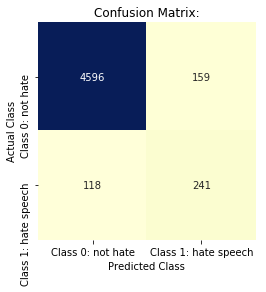

In [656]:
seaborn_confusion_matrix(y_val, nb_y_val_pred)

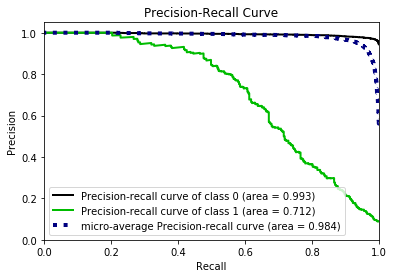

In [397]:
skplt.metrics.plot_precision_recall_curve(y_val, nb_y_val_prob)

Adjusted Accuracy: 0.956785295267892
Adjusted Precision: 0.7331081081081081
Adjusted Recall: 0.6044568245125348
Adjusted F1 Score: 0.6625954198473283




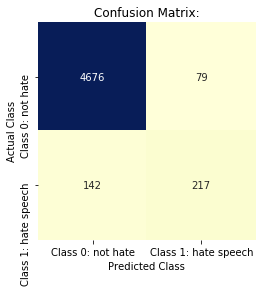

In [657]:
nb_adj_y_val, cm = adjust_threshold_and_score(y_val, nb_y_val_prob, .2)

## Final Naive Bayes Model:  Performance on Test Set 

In [424]:
#use smote and count vectorizer based on validation process
nb_test_model, nb_X_val, nb_y_train_pred, nb_y_val_pred, \
                nb_y_val_prob, nb_metrics_dict, nb_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, MultinomialNB(), count_vect, sampling= 'smote')

Adjusted Accuracy: 0.956785295267892
Adjusted Precision: 0.7331081081081081
Adjusted Recall: 0.6044568245125348
Adjusted F1 Score: 0.6625954198473283




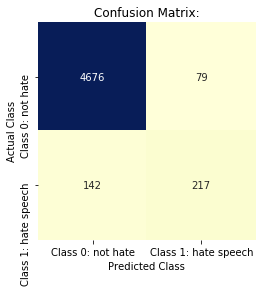

In [658]:
#final score based on adjusted threshold
nb_adj_y_true, cm = adjust_threshold_and_score(y_val, nb_y_val_prob, .2)

# Logistic Regression

### Comparing multiple vectorization methods and sampling methods

In [566]:
#Logistic Regression: lemmatizing + no adjustments
lr_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(solver = 'lbfgs', random_state = 10), 
                                            vectorization_list)

lr_results1

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.95,0.95,0.93
Train F1,0.89,0.47,0.47,0.14
Train Precision,0.99,0.88,0.89,0.96
Train Recall,0.80,0.32,0.32,0.08
Validation Accuracy,0.96,0.95,0.95,0.93
Validation F1,0.64,0.48,0.45,0.13
Validation Precision,0.85,0.89,0.85,0.87
Validation Recall,0.51,0.33,0.31,0.07


In [14]:
lr_results1.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [15]:
#Logistic Regression: compare vectorizers using lemmitizing + class balances
lr_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(class_weight= 'balanced', 
                            solver = 'lbfgs', random_state = 10), vectorization_list)
lr_results2

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.89,0.90,0.53
Train F1,0.93,0.54,0.56,0.22
Train Precision,0.87,0.38,0.40,0.12
Train Recall,0.99,0.92,0.93,0.93
Validation Accuracy,0.95,0.88,0.88,0.51
Validation F1,0.66,0.48,0.48,0.20
Validation Precision,0.62,0.34,0.34,0.11
Validation Recall,0.72,0.81,0.80,0.86


In [16]:
lr_results2.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [17]:
#Logistic Regression: compare vectorizers using lemmitizing + upsampling
lr_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(solver = 'lbfgs', 
                            random_state = 10), vectorization_list, sampling = 'upsample')
lr_results3

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.94,0.96,0.79
Train F1,0.99,0.94,0.96,0.77
Train Precision,0.99,0.92,0.94,0.86
Train Recall,1.00,0.96,0.98,0.70
Validation Accuracy,0.95,0.91,0.92,0.86
Validation F1,0.67,0.55,0.56,0.34
Validation Precision,0.63,0.43,0.44,0.25
Validation Recall,0.70,0.77,0.77,0.50


In [18]:
lr_results3.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [19]:
#Logistic Regression: compare vectorizers using lemmitizing + downsampling
lr_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(random_state = 10, solver = 'lbfgs'), 
                            vectorization_list, sampling = 'downsample')
lr_results4

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.93,0.94,0.82
Train F1,0.99,0.93,0.94,0.80
Train Precision,1.00,0.92,0.94,0.91
Train Recall,0.99,0.94,0.95,0.71
Validation Accuracy,0.85,0.84,0.83,0.82
Validation F1,0.44,0.42,0.41,0.30
Validation Precision,0.30,0.28,0.27,0.21
Validation Recall,0.84,0.84,0.83,0.55


In [20]:
lr_results4.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [21]:
#Logistic Regression: compare vectorizers using lemmitizing + smote
lr_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(random_state = 10, solver = 'lbfgs'), 
                            vectorization_list, sampling = 'smote', sample_class = 'not majority')
lr_results5

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.96,0.89,0.90,0.56
Train F1,0.75,0.52,0.55,0.22
Train Precision,0.66,0.38,0.40,0.13
Train Recall,0.87,0.83,0.84,0.89
Validation Accuracy,0.89,0.88,0.88,0.54
Validation F1,0.48,0.47,0.47,0.20
Validation Precision,0.36,0.34,0.35,0.11
Validation Recall,0.70,0.75,0.74,0.81


In [ ]:
lr_results5.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

### Grid Searching for Best Hyperparameters

In [660]:
np.random.seed(10)

logreg = LogisticRegression(random_state= 10)
c_space = np.linspace (.1, 10, 100)

parameters = {'C': c_space, 
          'penalty': ['l1', 'l2']}

scores = ['accuracy','recall','precision','f1']

lr_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [661]:
lr_gs_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, lr_gs, count_vect, sampling= 'upsample')

In [662]:
lr_gs_model.best_params_

{'C': 8.4, 'penalty': 'l1'}

In [679]:
lr_gs_df = pd.DataFrame(lr_gs_model.cv_results_)
lr_gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.151034,0.012401,0.017397,0.001059,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.879101,0.877287,0.887461,...,0.898588,0.895625,0.005108,200,0.875880,0.875500,0.885867,0.879083,0.004800,200
1,0.223268,0.024007,0.016195,0.001933,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.955442,0.958202,0.961120,...,0.946404,0.942777,0.003661,197,0.956000,0.959155,0.961750,0.958969,0.002351,197
2,0.168602,0.011501,0.017479,0.001458,0.2,l1,"{'C': 0.2, 'penalty': 'l1'}",0.926972,0.928864,0.932413,...,0.928292,0.927217,0.005202,199,0.926461,0.929575,0.932737,0.929591,0.002562,199
3,0.236551,0.028654,0.017443,0.001850,0.2,l2,"{'C': 0.2, 'penalty': 'l2'}",0.966562,0.966483,0.969006,...,0.955430,0.950890,0.004550,195,0.967071,0.967285,0.969461,0.967939,0.001080,195
4,0.191174,0.029167,0.015129,0.000764,0.3,l1,"{'C': 0.30000000000000004, 'penalty': 'l1'}",0.953549,0.952997,0.954732,...,0.943402,0.941663,0.004768,198,0.953916,0.953941,0.955303,0.954387,0.000648,198


In [665]:
lr_gs_df[lr_gs_df.rank_test_precision == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
84,0.266264,0.008697,0.017452,0.001364,4.3,l1,"{'C': 4.3, 'penalty': 'l1'}",0.983833,0.980678,0.982571,...,0.969464,0.968028,0.003165,1,0.98405,0.981027,0.982811,0.982629,0.001241,53


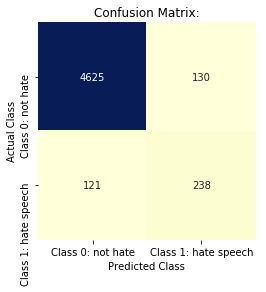

In [666]:
#want to reduce number of records predicted as 0 that are actually 1 
seaborn_confusion_matrix(y_val, lr_y_val_pred)

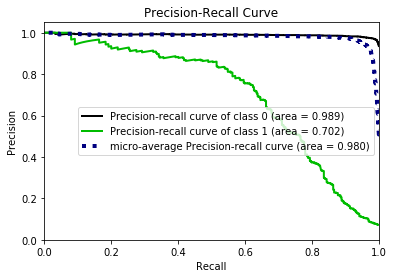

In [313]:
skplt.metrics.plot_precision_recall_curve(y_val, lr_y_val_prob)

Adjusted Accuracy: 0.9587407117716074
Adjusted Precision: 0.7466666666666667
Adjusted Recall: 0.6239554317548747
Adjusted F1 Score: 0.6798179059180577




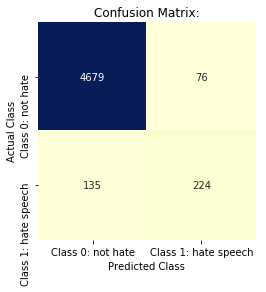

In [667]:
lr_pred_adj, cm = adjust_threshold_and_score(y_val, lr_y_val_prob, .2)

In [64]:
lr_pred_df['adjusted class'] = lr_pred_adj

In [59]:
lr_pred_df.head()

,prob 0,prob 1,predicted class,actual class,adjusted_class
17498,0.73,0.27,0,0,0
9203,1.00,0.00,0,0,0
17380,0.99,0.01,0,0,0
25176,1.00,0.00,0,0,0
3828,1.00,0.00,0,0,0


In [65]:
lr_misclassified_df = lr_pred_df[lr_pred_df['predicted class'] != lr_pred_df['actual class']]
lr_misclassified_df.head()

,prob 0,prob 1,predicted class,actual class,adjusted class
12608,0.94,0.06,0,1,0
23876,0.45,0.55,1,0,0
28669,0.75,0.25,0,1,0
14414,0.49,0.51,1,0,0
2748,0.72,0.28,0,1,0


In [69]:
lr_misclassified_df.shape

(210, 5)

In [70]:
lr_misclassified2_df = lr_misclassified_df[lr_misclassified_df['adjusted class'] != lr_misclassified_df['actual class']]
lr_misclassified2_df.head()

,prob 0,prob 1,predicted class,actual class,adjusted class
12608,0.94,0.06,0,1,0
28669,0.75,0.25,0,1,0
2748,0.72,0.28,0,1,0
8202,0.89,0.11,0,1,0
13596,0.61,0.39,0,1,0


In [71]:
lr_misclassified2_df.shape

(173, 5)

In [72]:
df.tweet[12608]

'a reson why so many muslims might be'

In [73]:
df.lem_tweet[28669]

'nazi swastika ebay trump donaldtrump republicwhitepower'

In [74]:
df.tweet[2748]

'ever notice how much scum #trump hires ?'

In [671]:
# import eli5
# from eli5 import explain_weights, explain_prediction
# from eli5.formatters import format_as_html, format_as_text, format_html_styles, fields

In [672]:
# eli5.show_weights(log, vec= count_vect, target_names= y_test, horizontal_layout=False)

In [673]:
# skplt.metrics.plot_precision_recall_curve(y_test, lr_y_prob_test)

## SVM


In [129]:
#SVM with lemmatizing + no class balance corrections
svm_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', probability = True, random_state = 10), 
                            vectorization_list)
svm_results1 

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.93,0.93,0.93,0.93
Train F1,0.00,0.00,0.00,0.00
Train Precision,0.00,0.00,0.00,0.00
Train Recall,0.00,0.00,0.00,0.00
Validation Accuracy,0.93,0.93,0.93,0.93
Validation F1,0.00,0.00,0.00,0.00
Validation Precision,0.00,0.00,0.00,0.00
Validation Recall,0.00,0.00,0.00,0.00


In [ ]:
# svm_results1.to_csv('data/SVM_results.csv',mode = 'a',header ='column_names')

In [130]:
#SVM with lemmatizing + class balance corrections
svm_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', class_weight = 'balanced', probability = True, random_state = 10), 
                            vectorization_list)
svm_results2

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.07,0.07,0.07,0.08
Train F1,0.13,0.13,0.13,0.13
Train Precision,0.07,0.07,0.07,0.07
Train Recall,1.00,1.00,1.00,1.00
Validation Accuracy,0.07,0.07,0.07,0.08
Validation F1,0.13,0.13,0.13,0.13
Validation Precision,0.07,0.07,0.07,0.07
Validation Recall,1.00,1.00,1.00,1.00


In [ ]:
# svm_results2.to_csv('data/SVM_results.csv', mode = 'a',header ='column_names')

In [680]:
# Note: won't successfully complete training; may be a memory issue

# svm_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
#                             y_train, X_val.lem_tweet, y_val, 
#                             SVC(gamma='auto', random_state = 10), 
#                             vectorization_list, sampling = 'upsample')
# svm_results3 

In [131]:
# SVM with lemmatizing + downsampling
svm_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma= 'auto', probability = True, random_state = 10), 
                            vectorization_list, sampling = 'downsample')
svm_results4 

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.51,0.84,0.80,0.54
Train F1,0.67,0.85,0.76,0.14
Train Precision,0.51,0.80,0.94,0.99
Train Recall,1.00,0.91,0.63,0.08
Validation Accuracy,0.10,0.74,0.89,0.93
Validation F1,0.13,0.32,0.45,0.13
Validation Precision,0.07,0.20,0.35,1.00
Validation Recall,1.00,0.89,0.60,0.07


In [681]:
# Note: won't successfully complete training; may be a memory issue

#svm_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
#                             y_train, X_val.lem_tweet, y_val, 
#                             SVC(gamma='auto', probability = True, random_state = 10), 
#                             vectorization_list, sampling = 'smote')
# svm_results5 

#### Grid Searching:

In [ ]:
# svc = SVC (random_state= 10)

# params = {
# 'C': [0.1,.2, .5, 0.8, 1, 1.5, 2.0, 3.0, 4.0, 5.0],
# 'kernel':['linear', 'rbf'],
# 'gamma' :[0.1,0.8,1,1.2,1.4],
# 'class_weight': [{0:5, 1:5}, {0:2, 1:8}, {0:4, 1:6}, {0:8, 1:2}]}

# scores = ['accuracy','recall','precision','f1']

# scv_rs = RandomizedSearchCV(rfc, param_distributions = parameters, scoring = scores, cv = 3, refit = 'f1')

# Random Forest

### Comparing Classifier Performance with Multiple Vectorizer Methods and Class Imbalance Corrections

In [117]:
#Random Forest: compare vectorizers with lemmatizing; no explicit class balance corrections
rfc_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), vectorization_list)
rfc_results1

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.99,0.99,0.95
Train F1,0.95,0.94,0.94,0.41
Train Precision,1.00,1.00,1.00,0.92
Train Recall,0.91,0.89,0.89,0.26
Validation Accuracy,0.96,0.95,0.96,0.93
Validation F1,0.61,0.55,0.58,0.20
Validation Precision,0.93,0.84,0.86,0.64
Validation Recall,0.45,0.41,0.44,0.12


In [118]:
# rfc_results1.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')


In [119]:
#Random Forest: compare vectorizers with lemmatizing and class weights balanced
rfc_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10, class_weight = 'balanced'), 
                            vectorization_list)
rfc_results2

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.99,0.99,0.61
Train F1,0.95,0.94,0.94,0.25
Train Precision,1.00,0.98,0.98,0.14
Train Recall,0.91,0.90,0.91,0.91
Validation Accuracy,0.96,0.95,0.95,0.60
Validation F1,0.54,0.54,0.55,0.21
Validation Precision,0.98,0.84,0.84,0.12
Validation Recall,0.37,0.40,0.41,0.77


In [120]:
# rfc_results2.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [121]:
#Random Forest: compare vectorizers with lemmatizing and upsampling
rfc_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'upsample')
rfc_results3

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,1.00,1.00,1.00,0.85
Train F1,1.00,1.00,1.00,0.83
Train Precision,1.00,1.00,1.00,0.94
Train Recall,1.00,1.00,1.00,0.75
Validation Accuracy,0.96,0.95,0.95,0.90
Validation F1,0.59,0.61,0.59,0.38
Validation Precision,0.93,0.75,0.77,0.33
Validation Recall,0.43,0.52,0.48,0.43


In [122]:
# rfc_results3.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [123]:
#Random Forest: compare vectorizers with lemmatizing and downsampling
rfc_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'downsample')
rfc_results4

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,0.99,0.99,0.87
Train F1,0.99,0.99,0.99,0.85
Train Precision,1.00,1.00,1.00,0.97
Train Recall,0.98,0.98,0.98,0.76
Validation Accuracy,0.86,0.84,0.83,0.80
Validation F1,0.42,0.39,0.38,0.26
Validation Precision,0.30,0.27,0.26,0.18
Validation Recall,0.73,0.74,0.74,0.50


In [124]:
# rfc_results4.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [125]:
#Random Forest: compare vectorizers with lemmatizing and smote
rfc_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'smote', sample_class = 'not majority')
rfc_results5

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.99,1.00,1.00,0.64
Train F1,0.96,0.99,0.99,0.25
Train Precision,0.95,0.98,0.99,0.15
Train Recall,0.96,0.99,0.99,0.86
Validation Accuracy,0.89,0.93,0.94,0.59
Validation F1,0.42,0.51,0.53,0.20
Validation Precision,0.34,0.52,0.56,0.12
Validation Recall,0.55,0.50,0.50,0.72


In [126]:
# rfc_results5.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

### Hypertuning Random Forest Hyperparameters: Count Vectorizer and no Class Imbalance Correction

In [627]:
np.random.seed(0)
rfc = RandomForestClassifier(random_state=10)

parameters = {'n_estimators' : [40, 60, 80, 100, 120],
'max_leaf_nodes' : [100, 200, 300, 400],
'random_state' : [10],
'max_depth': [5, 6, 7, 8, 10, 20, 25, 30],
 'verbose' : [0],
# 'class_weight': [{0:5, 1:5}, {0:2, 1:8}, {0:4, 1:6}, {0:6, 1: 4}, {0:8, 1:2}]}
'class_weight': ['balanced', 'balanced_subsample']}

scores = ['accuracy','recall','precision','f1']

rfc_rs = RandomizedSearchCV(rfc, param_distributions = parameters, scoring = scores, cv = 3, refit = 'f1')

In [628]:
rfc_rs_model, rfc_X_val, rfc_y_train_pred, rfc_y_val_pred, \
                rfc_y_val_prob, rfc_metrics_dict, rfc_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, rfc_rs, count_vect)

In [629]:
rfc_rs_model.best_params_

{'verbose': 0,
 'random_state': 10,
 'n_estimators': 60,
 'max_leaf_nodes': 400,
 'max_depth': 30,
 'class_weight': 'balanced'}

In [630]:
rfc_df = pd.DataFrame(rfc_rs_model.cv_results_)
rfc_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_verbose,param_random_state,param_n_estimators,param_max_leaf_nodes,param_max_depth,param_class_weight,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,1.266039,0.028208,0.205476,0.009403,0,10,60,100,6,balanced_subsample,...,0.374684,0.379603,0.032226,8,0.484472,0.430793,0.466877,0.460715,0.022343,8
1,3.215748,0.093453,0.362580,0.007181,0,10,100,400,10,balanced_subsample,...,0.471358,0.447791,0.024245,2,0.530290,0.505710,0.528926,0.521642,0.011279,2
2,0.606454,0.023982,0.156032,0.025850,0,10,40,400,5,balanced,...,0.333770,0.343461,0.041744,9,0.453645,0.388038,0.410628,0.417439,0.027214,10
3,0.877085,0.016684,0.131665,0.000259,0,10,40,200,8,balanced,...,0.382667,0.399158,0.076505,6,0.518593,0.402116,0.467427,0.462715,0.047669,7
4,1.371748,0.018131,0.194292,0.004815,0,10,60,400,7,balanced_subsample,...,0.415746,0.406288,0.029263,5,0.503534,0.454690,0.500832,0.486353,0.022415,5
5,2.271412,0.114878,0.328023,0.009873,0,10,100,100,8,balanced,...,0.425107,0.427636,0.046751,3,0.530806,0.463357,0.505513,0.499893,0.027821,3
6,1.382198,0.048633,0.219021,0.083370,0,10,40,100,10,balanced_subsample,...,0.386179,0.389652,0.047791,7,0.506837,0.421779,0.468750,0.465791,0.034788,6
7,2.770075,0.210571,0.327390,0.019271,0,10,100,200,8,balanced_subsample,...,0.426323,0.418492,0.038349,4,0.523466,0.464037,0.506372,0.497960,0.024980,4
8,1.653883,0.266970,0.287729,0.030700,0,10,80,200,5,balanced_subsample,...,0.347686,0.336403,0.015501,10,0.439510,0.426649,0.459133,0.441764,0.013357,9
9,5.370594,0.231870,0.388727,0.084183,0,10,60,400,30,balanced,...,0.696319,0.666629,0.041265,1,0.597619,0.562430,0.564677,0.574910,0.016085,1


In [631]:
rfc_df[rfc_df.rank_test_precision==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_verbose,param_random_state,param_n_estimators,param_max_leaf_nodes,param_max_depth,param_class_weight,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
9,5.370594,0.23187,0.388727,0.084183,0,10,60,400,30,balanced,...,0.696319,0.666629,0.041265,1,0.597619,0.56243,0.564677,0.57491,0.016085,1


In [632]:
rfc_rs.best_score_

0.5749095638785128

In [633]:
rfc_metrics_dict

{'Train Accuracy': 0.97,
 'Train Precision': 0.75,
 'Train Recall': 0.79,
 'Train F1': 0.77,
 'Validation Accuracy': 0.94,
 'Validation Precision': 0.57,
 'Validation Recall': 0.61,
 'Validation F1': 0.59}

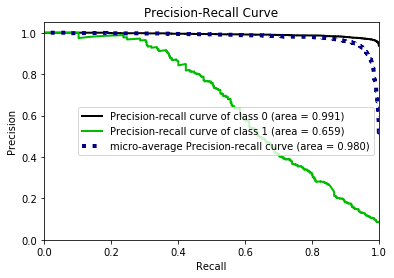

In [634]:
skplt.metrics.plot_precision_recall_curve(y_val, rfc_y_val_prob)

In [635]:
y_val.value_counts()

0    4755
1     359
Name: label, dtype: int64

In [637]:
rfc_y_val_pred.shape

(5114, 1)

Adjusted Accuracy: 0.95267892061009
Adjusted Precision: 0.7241379310344828
Adjusted Recall: 0.5264623955431755
Adjusted F1 Score: 0.6096774193548388




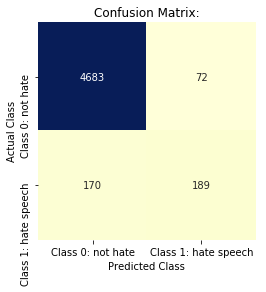

In [651]:
rfc_y_val_adj, cm = adjust_threshold_and_score(y_val, rfc_y_val_prob, .48)

###  Final Random Forest Model: Test Performance

In [595]:
rfc = RandomForestClassifier(n_estimators = 60, max_leaf_nodes = 400, 
                       max_depth = 30, class_weight = 'balanced', random_state = 10, verbose = 0)

In [653]:
rfc_test_model, rfc_X_val, rfc_y_model_pred, rfc_y_test_pred, \
                rfc_y_test_prob, rfc_metrics_dict, rfc_pred_df = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, 
                y_test, rfc, count_vect)

In [654]:
rfc_metrics_dict

{'Train Accuracy': 0.99,
 'Train Precision': 1.0,
 'Train Recall': 0.92,
 'Train F1': 0.96,
 'Validation Accuracy': 0.96,
 'Validation Precision': 0.94,
 'Validation Recall': 0.46,
 'Validation F1': 0.62}

Adjusted Accuracy: 0.9602690442671672
Adjusted Precision: 0.9409090909090909
Adjusted Recall: 0.46205357142857145
Adjusted F1 Score: 0.6197604790419162




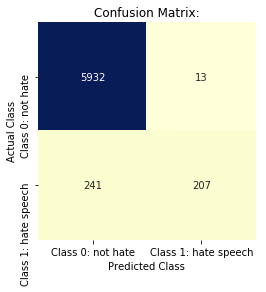

In [655]:
rfc_adj_y_test, cm = adjust_threshold_and_score(y_test, rfc_y_test_prob, .48)

# AdaBoost

### Comparison Across Multiple Vectorization and Class Imbalance Correction Methods

In [464]:
#AdaBoost with Decision Tree, lemmatizing + no class balance corrections
ab_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list)
ab_results1

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.95,0.94,0.94,0.93
Train F1,0.47,0.45,0.46,0.16
Train Precision,0.75,0.74,0.72,0.86
Train Recall,0.34,0.33,0.34,0.09
Validation Accuracy,0.95,0.95,0.94,0.93
Validation F1,0.46,0.47,0.47,0.12
Validation Precision,0.77,0.73,0.72,0.75
Validation Recall,0.33,0.35,0.35,0.07


In [119]:
#AdaBoost with Decision Tree, lemmatizing + class balance corrections
dct = DecisionTreeClassifier(class_weight = 'balanced')
ab_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(base_estimator = dct, random_state = 10), vectorization_list)
ab_results2

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,1.00,1.00,1.00,0.59
Train F1,1.00,0.98,0.98,0.25
Train Precision,1.00,0.97,0.97,0.15
Train Recall,1.00,1.00,1.00,0.99
Validation Accuracy,0.92,0.92,0.90,0.56
Validation F1,0.53,0.46,0.45,0.21
Validation Precision,0.44,0.42,0.37,0.12
Validation Recall,0.67,0.52,0.57,0.81


In [470]:
#AdaBoost with Decision Tree, lemmatizing + upsampling
ab_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'upsample')
ab_results3

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.77,0.77,0.77,0.61
Train F1,0.74,0.73,0.73,0.36
Train Precision,0.86,0.87,0.87,0.98
Train Recall,0.65,0.64,0.63,0.22
Validation Accuracy,0.88,0.88,0.89,0.94
Validation F1,0.43,0.43,0.44,0.31
Validation Precision,0.32,0.32,0.34,0.72
Validation Recall,0.65,0.63,0.62,0.20


In [471]:
#AdaBoost with Decision Tree, lemmatizing + downsampling
ab_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'downsample')
ab_results4

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.78,0.79,0.79,0.61
Train F1,0.76,0.78,0.78,0.36
Train Precision,0.83,0.83,0.83,0.98
Train Recall,0.70,0.74,0.74,0.22
Validation Accuracy,0.82,0.78,0.77,0.93
Validation F1,0.35,0.32,0.31,0.28
Validation Precision,0.24,0.20,0.19,0.43
Validation Recall,0.69,0.72,0.71,0.21


In [472]:
#AdaBoost with Decision Tree, lemmatizing + smote
ab_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'smote')
ab_results5

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.73,0.72,0.72,0.28
Train F1,0.26,0.27,0.27,0.16
Train Precision,0.16,0.16,0.17,0.09
Train Recall,0.68,0.73,0.74,0.97
Validation Accuracy,0.72,0.72,0.72,0.27
Validation F1,0.26,0.27,0.28,0.15
Validation Precision,0.16,0.17,0.17,0.08
Validation Recall,0.71,0.75,0.76,0.94


## XGBooster

In [122]:
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [123]:
xgb_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list)
xgb_results1

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.94,0.94,0.94,0.93
Train F1,0.34,0.36,0.36,0.14
Train Precision,0.93,0.95,0.94,0.96
Train Recall,0.21,0.22,0.22,0.08
Validation Accuracy,0.94,0.94,0.94,0.93
Validation F1,0.34,0.35,0.35,0.13
Validation Precision,0.92,0.91,0.89,0.87
Validation Recall,0.21,0.21,0.22,0.07


In [127]:
#XGB with scale and min child weight set to 1 to correct for class imbalance
xgb_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(scale_pos_weight = 1, min_child_weight = 1,
                            random_state =10), vectorization_list)
xgb_results2

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.94,0.94,0.94,0.93
Train F1,0.34,0.36,0.36,0.14
Train Precision,0.93,0.95,0.94,0.96
Train Recall,0.21,0.22,0.22,0.08
Validation Accuracy,0.94,0.94,0.94,0.93
Validation F1,0.34,0.35,0.35,0.13
Validation Precision,0.92,0.91,0.89,0.87
Validation Recall,0.21,0.21,0.22,0.07


In [124]:
xgb_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'upsample')
xgb_results3

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.81,0.81,0.82,0.65
Train F1,0.79,0.80,0.79,0.48
Train Precision,0.87,0.87,0.90,0.96
Train Recall,0.72,0.73,0.71,0.32
Validation Accuracy,0.87,0.87,0.89,0.93
Validation F1,0.43,0.41,0.45,0.35
Validation Precision,0.31,0.30,0.35,0.55
Validation Recall,0.67,0.65,0.63,0.25


In [125]:
xgb_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'downsample')
xgb_results4

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.79,0.81,0.81,0.64
Train F1,0.78,0.80,0.80,0.46
Train Precision,0.86,0.88,0.87,0.94
Train Recall,0.71,0.72,0.73,0.30
Validation Accuracy,0.83,0.83,0.82,0.90
Validation F1,0.37,0.35,0.35,0.26
Validation Precision,0.25,0.24,0.23,0.26
Validation Recall,0.70,0.66,0.69,0.26


In [126]:
xgb_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'smote')
xgb_results5

,COUNT_VECTORIZER,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_2_3
Train Accuracy,0.94,0.94,0.94,0.35
Train F1,0.38,0.49,0.50,0.17
Train Precision,0.77,0.56,0.56,0.09
Train Recall,0.25,0.44,0.45,0.96
Validation Accuracy,0.94,0.93,0.93,0.34
Validation F1,0.35,0.45,0.48,0.16
Validation Precision,0.70,0.48,0.51,0.09
Validation Recall,0.23,0.43,0.45,0.92


# Word to Vec: Training Model and Performing Classification 

### X-train pre-processing

In [10]:
X_train_token_list = list(X_train.tokenized_tweet)



In [169]:
X_train_token_sumlist = sum(X_train_token_list,[])
X_train_unique_tokens = set(X_train_token_sumlist)
print('The unique number of words in the training dataset is: {}'.format(len(X_train_unique_tokens)))

The unique number of words in the training dataset is: 28682


#### X-val pre-processing

In [11]:
X_val_token_list = list(X_val['tokenized_tweet'])

In [170]:
X_val_token_sumlist = sum(X_val_token_list,[])
X_val_unique_tokens = set(X_val_token_sumlist)

print('The unique number of words in the validation dataset is: {}'.format(len(X_val_unique_tokens)))

The unique number of words in the validation dataset is: 11761


#### X-test pre-processing

In [171]:
X_test_token_list = list(X_test['tokenized_tweet'])
X_test_token_sumlist = sum(X_test_token_list,[])

X_test_unique_tokens = set(X_test_token_sumlist)
print('The unique number of words in the training dataset is: {}'.format(len(X_test_unique_tokens)))

The unique number of words in the training dataset is: 13677


### Training Model

In [ ]:
from time import time
t = time()

w2v_model = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model.train(X_train_token_list, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

In [ ]:
# w2v_model.save('data/w2v.model')

In [14]:
w2v_model = gensim.models.Word2Vec.load('data/w2v.model')

In [149]:
w2v_vocab= w2v.wv.vocab

In [ ]:
w2v_vectors = w2v.wv.vectors

## Classification with Trained Word2Vec Embeddings

In [32]:
#create average vector for train and test from model; return list of numpy arrays are then stacked 

# X_train_w2v = np.concatenate([avg_word_vectors(sentence, w2v_model) for sentence in X_train_token_list])
# X_val_w2v = np.concatenate([avg_word_vectors(sentence, w2v_model) for sentence in X_val_token_list])

In [100]:
# with open('data/mean_w2v_vectors.pkl', 'wb') as f:
# 	pickle.dump([X_train_w2v, X_val_w2v], f)

with open('data/mean_glove_vectors.pkl', 'rb') as f:
    X_train_w2v, X_val_w2v = pickle.load(f)

In [101]:
classifier_list = [('LogisticRegression', LogisticRegression(random_state = 10)),
                    ('RandomForest', RandomForestClassifier(random_state = 10)),
                    ('AdaBoost', AdaBoostClassifier(random_state=10))]

In [103]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list)

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.94,0.99,0.94
Train F1,0.44,0.94,0.48
Train Precision,0.68,1.00,0.64
Train Recall,0.33,0.89,0.38
Validation Accuracy,0.94,0.94,0.94
Validation F1,0.41,0.42,0.45
Validation Precision,0.65,0.79,0.57
Validation Recall,0.30,0.29,0.36


In [104]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list)

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.94,0.99,0.94
Train F1,0.44,0.94,0.48
Train Precision,0.68,1.00,0.64
Train Recall,0.33,0.89,0.38
Validation Accuracy,0.94,0.94,0.94
Validation F1,0.41,0.42,0.45
Validation Precision,0.65,0.79,0.57
Validation Recall,0.30,0.29,0.36


In [105]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'smote')

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.86,1.00,0.86
Train F1,0.47,0.99,0.44
Train Precision,0.32,0.99,0.31
Train Recall,0.86,1.00,0.79
Validation Accuracy,0.86,0.94,0.85
Validation F1,0.45,0.56,0.41
Validation Precision,0.31,0.57,0.28
Validation Recall,0.82,0.56,0.75


In [84]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'upsample')

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.56,0.98,0.64
Train F1,0.56,0.98,0.66
Train Precision,0.56,0.97,0.64
Train Recall,0.56,1.00,0.68
Validation Accuracy,0.54,0.90,0.57
Validation F1,0.11,0.05,0.11
Validation Precision,0.06,0.09,0.06
Validation Recall,0.41,0.04,0.37


In [85]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'downsample')

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.58,0.98,0.74
Train F1,0.58,0.98,0.74
Train Precision,0.58,0.99,0.75
Train Recall,0.57,0.97,0.72
Validation Accuracy,0.51,0.45,0.41
Validation F1,0.15,0.12,0.13
Validation Precision,0.08,0.07,0.07
Validation Recall,0.61,0.55,0.65


#  GLoVe: Transfer Learning with Pre-Trained Word Embeddings

In [ ]:
# from gensim.scripts.glove2word2vec import glove2word2vec

# glove_input_file = 'data/glove.twitter.27B.100d.txt'
# glove_output_file = 'data/glove.txt.word2vec'
# glove2word2vec(glove_input_file, glove_output_file)

In [86]:
# glove_model = KeyedVectors.load_word2vec_format('data/glove.txt.word2vec', binary=False)

In [87]:
# X_train_glove = np.concatenate([avg_word_vectors(sentence, glove_model) for sentence in X_train_token_list])
# X_val_glove = np.concatenate([avg_word_vectors(sentence, glove_model) for sentence in X_val_token_list])

In [97]:
# with open('data/mean_glove_vectors.pkl', 'wb') as f:
# 	pickle.dump([X_train_glove, X_val_glove], f)

with open('data/mean_glove_vectors.pkl', 'rb') as f:
    X_train_glove, X_val_glove = pickle.load(f)

In [89]:
mean_embedding_compare_classification(X_train_glove, y_train, X_val_glove, y_val, classifier_list)

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.94,0.99,0.94
Train F1,0.44,0.94,0.48
Train Precision,0.68,1.00,0.64
Train Recall,0.33,0.89,0.38
Validation Accuracy,0.94,0.94,0.94
Validation F1,0.41,0.42,0.45
Validation Precision,0.65,0.79,0.57
Validation Recall,0.30,0.29,0.36


In [90]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'smote')

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.84,1.00,0.84
Train F1,0.43,0.99,0.41
Train Precision,0.29,0.98,0.28
Train Recall,0.84,1.00,0.80
Validation Accuracy,0.84,0.93,0.84
Validation F1,0.43,0.52,0.40
Validation Precision,0.28,0.50,0.27
Validation Recall,0.86,0.53,0.78


In [91]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'upsample')

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.56,0.98,0.64
Train F1,0.56,0.98,0.66
Train Precision,0.56,0.97,0.64
Train Recall,0.56,1.00,0.68
Validation Accuracy,0.54,0.90,0.57
Validation F1,0.11,0.05,0.11
Validation Precision,0.06,0.09,0.06
Validation Recall,0.41,0.04,0.37


In [92]:
mean_embedding_compare_classification(X_train_w2v, y_train, X_val_w2v, y_val, classifier_list, 
                                      sampling = 'downsample')

,LogisticRegression,RandomForest,AdaBoost
Train Accuracy,0.58,0.98,0.74
Train F1,0.58,0.98,0.74
Train Precision,0.58,0.99,0.75
Train Recall,0.57,0.97,0.72
Validation Accuracy,0.51,0.45,0.41
Validation F1,0.15,0.12,0.13
Validation Precision,0.08,0.07,0.07
Validation Recall,0.61,0.55,0.65


#  Testing Scraped Trump Tweets

In [ ]:
trump_df= pd.read_csv('data/cleaned-trump-tweet.csv')
trump_df.head()

In [ ]:
X_train_countvect =  count_vect.fit_transform(X_train_up.lem_tweet)

In [ ]:
logreg = LogisticRegression(class_weight='balanced')

In [ ]:
logreg.fit(X_train_countvect, y_train_up)

In [ ]:
X_trump = count_vect.transform(trump_df.lem_tweet)

In [ ]:
X_trump = X_trump.toarray()

In [ ]:
X_trump.shape

In [ ]:
y_trump_predict = logreg.predict(X_trump)

In [ ]:
y_trump_predict

In [ ]:
trump_df['predictions'] = y_trump_predict

In [ ]:
y_trump_predict_prob = logreg.predict_proba(X_trump)

In [ ]:
y_trump_predict_prob = pd.DataFrame(y_trump_predict_prob)

In [ ]:
trump_df['predict_probability'] = y_trump_predict_prob[0]

In [ ]:
trump_df = trump_df[['tweet','predictions', 'predict_probability']]


In [ ]:
trump0 = trump_df[trump_df.predictions == 0]

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
trump0.tweet

In [ ]:
trump_df

In [ ]:
trump_df[trump_df.predictions == 0]

In [ ]:
trump1 = trump_df[trump_df.predictions == 1]

In [ ]:
trump1.tweet